<a href="https://colab.research.google.com/github/alongstar518/cs221_finalproject/blob/master/cs221_final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CS221 Final Project: Steel Defect Detection 


### install packages

In [0]:
# No for now

### Import necessary libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm_notebook
import cv2
from PIL import Image
import shutil

import torch
import torch.nn as nn
import torch.optim as optim 
import torchvision
from torchvision import models
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as utils
from torchvision import transforms
import torch.nn.functional as F
import tensorboard
from tensorboard import notebook
from torch.utils.tensorboard import SummaryWriter

### Print torch and cuda information

In [353]:
print("torch version: {}".format(torch.__version__))
print("Cuda device avaliablity: {}".format(torch.cuda.is_available()))
print("Cuda device name: {}".format(torch.cuda.get_device_name()))
print("Cuda device Capilibility: {}".format(
    torch.cuda.get_device_capability(device=None)
  )
)
gpu_ram = (
    torch.cuda.get_device_properties(device=None).total_memory / (1024) **3
)
print(f"GPU RAM: {gpu_ram} GB")

torch version: 1.3.0+cu100
Cuda device avaliablity: True
Cuda device name: Tesla P100-PCIE-16GB
Cuda device Capilibility: (6, 0)
GPU RAM: 15.8992919921875 GB


### configs


basic config:

In [0]:
reload_data = True
clear_tensor_board_history = False
reload_last_model = False
leave_progress_bar = False
inference_mode = False
# path to local project folder contains the data
path = "/home/user/git/cs221_finalproject"
data_path = os.path.join(path, "data")
train_data_percent = 0.8
eval_data_percent = 0.1
test_data_percent = 0.1 # used only when we don`t have any eval set.

hyperparamters:

In [0]:
batch_size = 32
n_classes = 1
total_epochs = 100 
weight_decay=1e-4
lr = 0.01
momentum=0.9
eval_interval = 200

### download data

In [356]:
try:
  # delay import so we can run on local machine
  # this also check if run it on google drive or not . if it is not, it will 
  # avoiding runing from google colab, but running from local.
  from google.colab import drive
  path = "/content/drive/My Drive/share/"
  remote_data_path = os.path.join(path, "data")
  data_path = "/content/data"
  data_zip_path = os.path.join(
        remote_data_path, "severstal-steel-defect-detection.zip"
      )
  model_save_path = path
  data_zip_path_dst = "/content/severstal-steel-defect-detection.zip"
  res18_path = os.path.join(remote_data_path, "resnet18")
  os.makedirs(data_path, exist_ok=True)
  res18_path_dst = os.path.join(data_path, "resnet18")
  # you may find res18 folder here:
  # "https://drive.google.com/drive/folders/
  #  1KFKRraGbNUICgkgSabzrfHeJzYc5YE0W?usp=sharing"

  if reload_data:
    print("login to google drive")
    drive.mount('/content/drive')
    print("Copy res18 folder:")
    shutil.copytree(res18_path, res18_path_dst)
    print("Copy raw data from {} to {}".format(
        data_zip_path, data_zip_path_dst)
    )
    shutil.copy(data_zip_path, "/content")

    print("unzip raw data...")
    os.system("unzip {} -d {}".format(data_zip_path_dst, data_path))
    
    print("give back missing permissions for unzipping")
    os.system(
      "chmod +wrx /content/data/train_images.zip /content/data/test_images.zip"
    )
    
    print("unzipping data...")
    os.system("unzip {} -d {}".format(
        os.path.join(data_path,"train_images.zip"), 
        os.path.join(data_path,"train_images")
        )
    )
    os.system("unzip {} -d {}".format(
        os.path.join(data_path,"test_images.zip"), 
        os.path.join(data_path,"test_images")
      )
    )
    !ls /content/data
except Exception as e:
  print(e)
  print("Running on local machine.")
finally:
  model_save_path = os.path.join(path, "best.pth")


login to google drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Copy res18 folder:
[Errno 17] File exists: '/content/data/resnet18'
Running on local machine.


In [357]:
tr = pd.read_csv(os.path.join(data_path, 'train.csv'))
print(len(tr))
tr.head()

50272


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [358]:
df_train = tr[tr['EncodedPixels'].notnull()].reset_index(drop=True)
df_train = df_train[df_train['ImageId_ClassId']
.apply(lambda x: x.split('_')[1] == '4')].reset_index(drop=True)
print(len(df_train))
df_train.head()

801


,ImageId_ClassId,EncodedPixels
0,000f6bf48.jpg_4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
1,0025bde0c.jpg_4,315139 8 315395 15 315651 16 315906 17 316162 ...
2,002af848d.jpg_4,290800 6 291055 13 291311 15 291566 18 291822 ...
3,0030401a5.jpg_4,186833 1 187089 3 187344 6 187600 7 187855 10 ...
4,008621629.jpg_4,215548 3 215798 9 216051 12 216306 13 216560 1...


### data preprocessing function

In [0]:
# Decod
def rle2mask(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

# Encode
def mask2rle(img):
    tmp = np.rot90( np.flipud( img ), k=3 )
    rle = []
    lastColor = 0;
    startpos = 0
    endpos = 0

    tmp = tmp.reshape(-1,1)   
    for i in range( len(tmp) ):
        if (lastColor==0) and tmp[i]>0:
            startpos = i
            lastColor = 1
        elif (lastColor==1)and(tmp[i]==0):
            endpos = i-1
            lastColor = 0
            rle.append( str(startpos)+' '+str(endpos-startpos+1) )
    return " ".join(rle)

### Display some sample images

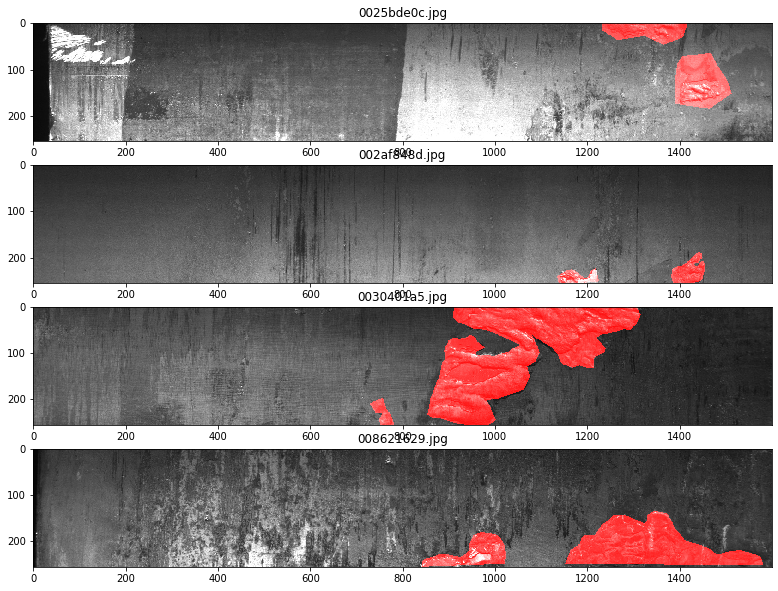

In [360]:
columns = 1
rows = 4
fig = plt.figure(figsize=(20,columns*rows+6))
for i in range(1,columns*rows+1):
    fn = df_train['ImageId_ClassId'].str[:-2].iloc[i]
    fig.add_subplot(rows, columns, i).set_title(fn)
    img = cv2.imread(data_path + '/train_images/'+fn)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = rle2mask(df_train['EncodedPixels'].iloc[i], (256, 1600))
    img[mask==1,0] = 255
    plt.imshow(img)
plt.show()

### Create train Dataset argumentation and DataLoader

In [0]:
class ImageData(Dataset):
    def __init__(self, df, transform, subset="train"):
        super().__init__()
        self.df = df
        self.transform = transform
        self.subset = subset
        
        if self.subset == "train":
            self.data_path = data_path + '/train_images/'
        elif self.subset == "test":
            self.data_path = data_path + '/test_images/'

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):                      
        fn = self.df['ImageId_ClassId'].iloc[index].split('_')[0]         
        img = Image.open(self.data_path + fn)
        img = self.transform(img)

        if self.subset == 'train': 
            mask = rle2mask(self.df['EncodedPixels'].iloc[index], (256, 1600))
            mask = transforms.ToPILImage()(mask)            
            mask = self.transform(mask)
            return img, mask
        else: 
            mask = None
            return img  

In [0]:
# Not enable augumentation yet
# This will need argument the ground truth.
data_transf = transforms.Compose(
    [
     transforms.Resize((256, 256)),
     transforms.ToTensor()
    ]
)

train_indx = int(len(df_train) * train_data_percent)
df_tr = df_train[0: train_indx]

eval_indx = int(len(df_train) * eval_data_percent) + train_indx
df_eval = df_train[train_indx: eval_indx]

df_test = df_train[eval_indx:]

train_data = ImageData(df = df_tr, transform = data_transf)
train_loader = DataLoader(
    dataset = train_data, batch_size=batch_size, shuffle=True
  )

eval_data = ImageData(df = df_eval, transform = data_transf)
eval_loader = DataLoader(dataset = eval_data)

test_data = ImageData(df = df_test, transform = data_transf)
test_loader = DataLoader(dataset = test_data)

### Show some image and ground truth (masks)

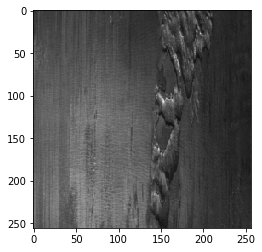

In [363]:
plt.imshow(train_data[3][0].permute(1, 2, 0))

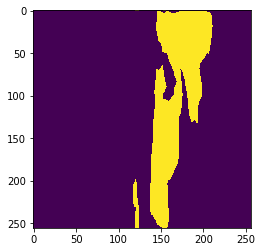

In [364]:
plt.imshow(np.squeeze(train_data[3][1].permute(1, 2, 0)))

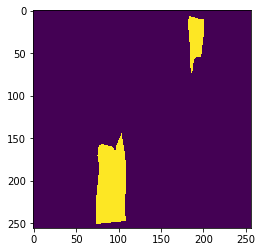

In [365]:
plt.imshow(np.squeeze(eval_data[10][1].permute(1,2,0)))

### Models

UNet:

In [0]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )


class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18()
        self.base_model.load_state_dict(torch.load(os.path.join(data_path, "resnet18/resnet18.pth")))
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3])
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5])
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

### Train Preparation

In [367]:
model = UNet(n_class=1).cuda()
if reload_last_model and os.path.exists(model_save_path):
  print("Loading model from {}".format(model_save_path))
  model.load_state_dict(torch.load(model_save_path))
else:
  print("Not load model, train from scrath")
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(
    model.parameters(), weight_decay=weight_decay, lr = lr, momentum=momentum
)

Not load model, train from scrath


### training eval and test functions

Get LR value if we use lr decay

In [0]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

Eval Matrics:

In [0]:
SMOOTH = 1e-6

def dice_coefficient(x, y):
  """
  :param X: numpy array
  :param y: numpy array
  :return: float, dice coefficient for one x, y pair
  x, y is mask the preidiction values (mask)
  """
  x = x.squeeze()
  y = y.squeeze()
  #print(sum(((x*y) > 0)))
  #print(sum((x+y) > 0))
  return 2. * ((x == 1) & (y == 1)).sum(1, 2) / (np.sum(x == 1) + np.sum(y == 1)).sum(1, 2)


def iou_numpy(outputs: np.array, labels: np.array):
    outputs = outputs.squeeze(1)
    
    intersection = ((outputs == 1) & (labels == 1)).sum((1, 2))
    union = ((outputs == 1) | (labels == 1)).sum((1, 2))
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    
    thresholded = np.ceil(np.clip(20 * (iou - 0.5), 0, 10)) / 10
    
    return thresholded


Inference:

In [0]:
def predict(model, data_loader, resize=False, out_mask=True):
    predict = []
    Y = []
    raw = []
    model.eval()
    print("Predicting...")
    total = 0
    losses = []
    with tqdm_notebook(total=len(data_loader.dataset), leave=leave_progress_bar) as pbar:
      for data, y in data_loader:
        o = model(data.cuda())  
        o = o.cpu().detach().numpy() * (-1)
        tmp = np.copy(o)
        loss = criterion(torch.tensor(tmp), y)
        losses.append(loss)

        mn = np.mean(o)*1.2
        tmp[tmp < mn] = 0
        tmp[tmp > mn] = 1
        y_tmp = np.mean(y.numpy())*1.2
        y[y < y_tmp] = 0
        y[y > y_tmp] = 1

        predict.append(tmp)
        raw.append(data)
        Y.append(y)

        pbar.update(1)
    predict_loss = np.average(losses)
    print(f"Predict Loss = {predict_loss}")
    return predict, Y, raw, predict_loss


Eval Data:

In [0]:
def eval_data_set(model, data_loader, matrics):
  corr = []
  predictions, Y, raw, loss = predict(model, data_loader)
  for i, mask in enumerate(predictions):
    corr.append(matrics(mask, Y[i].numpy()))
  return np.mean(corr), predictions, Y, raw, loss

Tensorbaord Functions

In [0]:
if clear_tensor_board_history:
  shutil.rmtree("/content/runs", ignore_errors=True)
  os.mkdir("/content/runs")

Launch Tensorbaord:

In [373]:
%load_ext tensorboard
%tensorboard --logdir=runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 9039), started 2:39:09 ago. (Use '!kill 9039' to kill it.)

### Training

In [374]:
if inference_mode: 
  total_epochs = 0
summary_writter = SummaryWriter() # in ./run by default
total_it = 0
last_result = 0
current_it = 1
for epoch in range(total_epochs):
  print(f"Epoch: {epoch}")
  model.train()
  with tqdm_notebook(total=len(train_loader.dataset), leave=leave_progress_bar) as pbar:   
    for it, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        data_len = len(data)
        pbar.update(len(data))
        pbar.set_postfix(epoch=epoch, loss=loss.item())
        total_it += data_len
        summary_writter.add_scalar("Loss/train", loss.item(), total_it)
        summary_writter.add_scalar("LR/train", get_lr(optimizer), total_it)
        summary_writter.flush()
    # eval after each epoch
    corr, predictions, raw_truth, raw, loss = eval_data_set(
          model, eval_loader, iou_numpy
        )
    summary_writter.add_scalar("MDC/evaluation", corr, total_it)
    summary_writter.add_scalar("Loss/train", loss.item(), total_it)
    images_to_add_raw = []
    images_to_add_predict = []
    images_to_add_y = []
    for i, prediction in enumerate(predictions):
        if i // 10 == 0:
          images_to_add_raw.append(raw[i].squeeze(0))
          images_to_add_predict.append(torch.tensor(prediction).squeeze(1))
          images_to_add_y.append(raw_truth[i].squeeze(1))
        current_it += 1
    
    summary_writter.add_image(
      f'{epoch}_raw_img', 
      torchvision.utils.make_grid(images_to_add_raw, nrow=100), 
      epoch
    )
    summary_writter.add_image(
      f'{epoch}_prediction', 
      torchvision.utils.make_grid(images_to_add_predict, nrow=100), 
      epoch
    )
    summary_writter.add_image(
        f'{epoch}_ground_truth', 
        torchvision.utils.make_grid(images_to_add_y, nrow=100), 
        epoch
    )
    print("Result = {}".format(corr))
    if corr > last_result:
      print("Saving Model...")
      torch.save(model.state_dict(), model_save_path)
      last_result = corr
    summary_writter.flush()
summary_writter.close()

Epoch: 0


Predicting...


Predict Loss = 5.445016860961914
Result = 0.4878662109375
Saving Model...
Epoch: 1


Predicting...


Predict Loss = 29.959339141845703
Result = 0.4336083984375
Epoch: 2


Predicting...


Predict Loss = 23.58714485168457
Result = 0.4749951171875
Epoch: 3


Predicting...


Predict Loss = 17.798954010009766
Result = 0.471240234375
Epoch: 4


Predicting...


Predict Loss = 14.669214248657227
Result = 0.483544921875
Epoch: 5


Predicting...


Predict Loss = 12.658477783203125
Result = 0.5304101562500001
Saving Model...
Epoch: 6


Predicting...


Predict Loss = 11.466687202453613
Result = 0.5345703125
Saving Model...
Epoch: 7


Predicting...


Predict Loss = 10.63648796081543
Result = 0.5437353515625001
Saving Model...
Epoch: 8


Predicting...


Predict Loss = 10.0110502243042
Result = 0.5517382812499999
Saving Model...
Epoch: 9


Predicting...


Predict Loss = 9.565435409545898
Result = 0.5592578125
Saving Model...
Epoch: 10


Predicting...


Predict Loss = 9.250535011291504
Result = 0.5592724609374999
Saving Model...
Epoch: 11


Predicting...


Predict Loss = 9.04609489440918
Result = 0.5643750000000001
Saving Model...
Epoch: 12


Predicting...


Predict Loss = 8.88569450378418
Result = 0.5666943359375
Saving Model...
Epoch: 13


Predicting...


Predict Loss = 8.772732734680176
Result = 0.56234375
Epoch: 14


Predicting...


Predict Loss = 8.689714431762695
Result = 0.567529296875
Saving Model...
Epoch: 15


Predicting...


Predict Loss = 8.64842414855957
Result = 0.5727001953125
Saving Model...
Epoch: 16


Predicting...


Predict Loss = 8.607417106628418
Result = 0.5716943359375
Epoch: 17


Predicting...


Predict Loss = 8.590866088867188
Result = 0.5701611328125
Epoch: 18


Predicting...


Predict Loss = 8.559206008911133
Result = 0.57638671875
Saving Model...
Epoch: 19


Predicting...


Predict Loss = 8.548746109008789
Result = 0.580341796875
Saving Model...
Epoch: 20


Predicting...


Predict Loss = 8.541044235229492
Result = 0.5816162109375
Saving Model...
Epoch: 21


Predicting...


Predict Loss = 8.532889366149902
Result = 0.5821337890624999
Saving Model...
Epoch: 22


Predicting...


Predict Loss = 8.524736404418945
Result = 0.5822705078125001
Saving Model...
Epoch: 23


Predicting...


Predict Loss = 8.524911880493164
Result = 0.584033203125
Saving Model...
Epoch: 24


Predicting...


Predict Loss = 8.519208908081055
Result = 0.5855224609375
Saving Model...
Epoch: 25


Predicting...


Predict Loss = 8.500994682312012
Result = 0.585478515625
Epoch: 26


Predicting...


Predict Loss = 8.46806812286377
Result = 0.5809228515625
Epoch: 27


Predicting...


Predict Loss = 8.46187973022461
Result = 0.6079687500000001
Saving Model...
Epoch: 28


Predicting...


Predict Loss = 8.476834297180176
Result = 0.61466796875
Saving Model...
Epoch: 29


Predicting...


Predict Loss = 8.458348274230957
Result = 0.6145703124999999
Epoch: 30


Predicting...


Predict Loss = 8.449487686157227
Result = 0.6202343750000001
Saving Model...
Epoch: 31


Predicting...


Predict Loss = 8.442258834838867
Result = 0.6245996093749999
Saving Model...
Epoch: 32


Predicting...


Predict Loss = 8.442045211791992
Result = 0.6259033203125
Saving Model...
Epoch: 33


Predicting...


Predict Loss = 8.438356399536133
Result = 0.6307714843750001
Saving Model...
Epoch: 34


Predicting...


Predict Loss = 8.421123504638672
Result = 0.6314111328124999
Saving Model...
Epoch: 35


Predicting...


Predict Loss = 8.411672592163086
Result = 0.6317675781250001
Saving Model...
Epoch: 36


Predicting...


Predict Loss = 8.418539047241211
Result = 0.6312890625
Epoch: 37


Predicting...


Predict Loss = 8.405774116516113
Result = 0.6353857421875
Saving Model...
Epoch: 38


Predicting...


Predict Loss = 8.403447151184082
Result = 0.6371923828125
Saving Model...
Epoch: 39


Predicting...


Predict Loss = 8.40997314453125
Result = 0.63857421875
Saving Model...
Epoch: 40


Predicting...


Predict Loss = 8.415766716003418
Result = 0.64169921875
Saving Model...
Epoch: 41


Predicting...


Predict Loss = 8.405730247497559
Result = 0.6423583984375001
Saving Model...
Epoch: 42


Predicting...


Predict Loss = 8.400774002075195
Result = 0.64416015625
Saving Model...
Epoch: 43


Predicting...


Predict Loss = 8.390983581542969
Result = 0.6422119140625
Epoch: 44


Predicting...


Predict Loss = 8.38676643371582
Result = 0.645126953125
Saving Model...
Epoch: 45


Predicting...


Predict Loss = 8.392970085144043
Result = 0.6472119140624999
Saving Model...
Epoch: 46


Predicting...


Predict Loss = 8.37989330291748
Result = 0.6468310546874999
Epoch: 47


Predicting...


Predict Loss = 8.392258644104004
Result = 0.651337890625
Saving Model...
Epoch: 48


Predicting...


Predict Loss = 8.396993637084961
Result = 0.652666015625
Saving Model...
Epoch: 49


Predicting...


Predict Loss = 8.389039993286133
Result = 0.6533203125
Saving Model...
Epoch: 50


Predicting...


Predict Loss = 8.390584945678711
Result = 0.656220703125
Saving Model...
Epoch: 51


Predicting...


Predict Loss = 8.376764297485352
Result = 0.6569775390625
Saving Model...
Epoch: 52


Predicting...


Predict Loss = 8.366462707519531
Result = 0.655107421875
Epoch: 53


Predicting...


Predict Loss = 8.385760307312012
Result = 0.659453125
Saving Model...
Epoch: 54


Predicting...


Predict Loss = 8.38110065460205
Result = 0.660107421875
Saving Model...
Epoch: 55


Predicting...


Predict Loss = 8.382630348205566
Result = 0.6643212890625
Saving Model...
Epoch: 56


Predicting...


Predict Loss = 8.375279426574707
Result = 0.6648486328125
Saving Model...
Epoch: 57


Predicting...


Predict Loss = 8.365720748901367
Result = 0.663505859375
Epoch: 58


Predicting...


Predict Loss = 8.37641429901123
Result = 0.6647363281249999
Epoch: 59


Predicting...


Predict Loss = 8.365083694458008
Result = 0.6671435546875
Saving Model...
Epoch: 60


Predicting...


Predict Loss = 8.357307434082031
Result = 0.6653466796875
Epoch: 61


Predicting...


Predict Loss = 8.361400604248047
Result = 0.668173828125
Saving Model...
Epoch: 62


Predicting...


Predict Loss = 8.354084968566895
Result = 0.6691943359375
Saving Model...
Epoch: 63


Predicting...


Predict Loss = 8.354096412658691
Result = 0.6708593749999999
Saving Model...
Epoch: 64


Predicting...


Predict Loss = 8.368592262268066
Result = 0.6737353515625
Saving Model...
Epoch: 65


Predicting...


Predict Loss = 8.356579780578613
Result = 0.6714990234375
Epoch: 66


Predicting...


Predict Loss = 8.360679626464844
Result = 0.6766064453125
Saving Model...
Epoch: 67


Predicting...


Predict Loss = 8.365707397460938
Result = 0.6775341796875
Saving Model...
Epoch: 68


Predicting...


Predict Loss = 8.356290817260742
Result = 0.673984375
Epoch: 69


Predicting...


Predict Loss = 8.360796928405762
Result = 0.67919921875
Saving Model...
Epoch: 70


Predicting...


Predict Loss = 8.352663040161133
Result = 0.680478515625
Saving Model...
Epoch: 71


Predicting...


Predict Loss = 8.344629287719727
Result = 0.6814892578125
Saving Model...
Epoch: 72


Predicting...


Predict Loss = 8.350878715515137
Result = 0.6814453125
Epoch: 73


Predicting...


Predict Loss = 8.341988563537598
Result = 0.6812841796875
Epoch: 74


Predicting...


Predict Loss = 8.350508689880371
Result = 0.6841552734375
Saving Model...
Epoch: 75


Predicting...


Predict Loss = 8.351163864135742
Result = 0.683505859375
Epoch: 76


Predicting...


Predict Loss = 8.333827018737793
Result = 0.68330078125
Epoch: 77


Predicting...


Predict Loss = 8.329627990722656
Result = 0.6833740234375
Epoch: 78


Predicting...


Predict Loss = 8.323728561401367
Result = 0.6829736328125
Epoch: 79


Predicting...


Predict Loss = 8.334177017211914
Result = 0.6871142578125001
Saving Model...
Epoch: 80


Predicting...


Predict Loss = 8.338045120239258
Result = 0.6873193359374999
Saving Model...
Epoch: 81


Predicting...


Predict Loss = 8.355148315429688
Result = 0.69078125
Saving Model...
Epoch: 82


Predicting...


Predict Loss = 8.316476821899414
Result = 0.6881201171875
Epoch: 83


Predicting...


Predict Loss = 8.343864440917969
Result = 0.6922314453124999
Saving Model...
Epoch: 84


Predicting...


Predict Loss = 8.336507797241211
Result = 0.6919287109375001
Epoch: 85


Predicting...


Predict Loss = 8.34046459197998
Result = 0.6938916015624998
Saving Model...
Epoch: 86


Predicting...


Predict Loss = 8.335118293762207
Result = 0.6914404296875001
Epoch: 87


Predicting...


Predict Loss = 8.325051307678223
Result = 0.6935302734375
Epoch: 88


Predicting...


Predict Loss = 8.326818466186523
Result = 0.6941748046874999
Saving Model...
Epoch: 89


Predicting...


Predict Loss = 8.319781303405762
Result = 0.6926123046875
Epoch: 90


Predicting...


Predict Loss = 8.322271347045898
Result = 0.6925976562499999
Epoch: 91


Predicting...


Predict Loss = 8.320270538330078
Result = 0.6937060546874999
Epoch: 92


Predicting...


Predict Loss = 8.340774536132812
Result = 0.698251953125
Saving Model...
Epoch: 93


Predicting...


Predict Loss = 8.343449592590332
Result = 0.6997998046875
Saving Model...
Epoch: 94


Predicting...


Predict Loss = 8.344926834106445
Result = 0.6993603515625
Epoch: 95


Predicting...


Predict Loss = 8.3212251663208
Result = 0.6980078125
Epoch: 96


Predicting...


Predict Loss = 8.316523551940918
Result = 0.6985253906250001
Epoch: 97


Predicting...


Predict Loss = 8.312066078186035
Result = 0.69953125
Epoch: 98


Predicting...


Predict Loss = 8.327126502990723
Result = 0.6999072265624999
Saving Model...
Epoch: 99


Predicting...


Predict Loss = 8.315130233764648
Result = 0.6981640625


### Show one prediction on image from eval dataset

IOU = [0.]


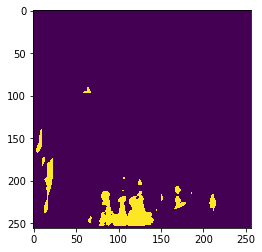

In [377]:
x = eval_data[6][0].unsqueeze(0)
y = eval_data[6][1].numpy()
o = model(x.cuda())  
o = o.cpu().detach().numpy() * (-1)
tmp = np.copy(o)
mn = np.mean(o)*1.2
tmp[tmp<mn] = 0
tmp[tmp>mn] = 1
plt.imshow(np.squeeze(tmp))
print("IOU = {}".format(iou_numpy(tmp, y)))

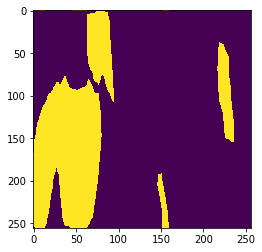

In [378]:
plt.imshow(np.squeeze(train_data[6][1]))

### Test on Test Set

In [376]:
corr, _, _, _, _ = eval_data_set(model, test_loader, iou_numpy)
print("Test set Corr = {}".format(corr))

Predicting...


Predict Loss = 8.351173400878906
Test set Corr = 0.6745756172839507
